<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PEC2</p>
<p style="margin: 0; text-align:right;">2022-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 2: Redes neuronales recurrentes con Keras

A lo largo de esta práctica vamos a implementar varios modelos de redes neuronales recurrentes para la detección, clasificación y localización de errores en datos temporales producidos por varios sensores. 

<u>Consideraciones generales</u>: 

- Esta PEC debe realizarse de forma **estrictamente individual**. Cualquier indicio de copia será penalizado con un suspenso (D) para todas las partes implicadas y la posible evaluación negativa de la asignatura de forma íntegra.
- Es necesario que el estudiante indique **todas las fuentes** que ha utilizado para la realización de la PEC. De no ser así, se considerará que el estudiante ha cometido plagio, siendo penalizado con un suspenso (D) y la posible evaluación negativa de la asignatura de forma íntegra.

<u>Formato de la entrega</u>:

- Algunos ejercicios pueden suponer varios minutos de ejecución, por lo que la entrega debe hacerse en **formato notebook** y en **formato html**, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a HTML desde el menú File $\to$ Download as $\to$ HTML.
- Existe un tipo de celda especial para albergar texto. Este tipo de celda os será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de la actividad. Para cambiar el tipo de celda a este tipo, en el menú: Cell $\to$ Cell Type $\to$ Markdown.

# 0. Contexto y carga de librerias

En esta PEC vamos a utilizar redes recurrentes para trabajar con datos temporales. Los datos deberán ser descargados desde este google drive:

[<h3><center>datos</center></h3>](https://drive.google.com/drive/folders/1n-kWjxRXXd4_vRPuctFH6qQVll7kcyUH?usp=share_link)

y los guardaremos en una carpeta `/data` que estará en la carpeta raíz con el notebook. Los datos constan de la lectura de 3 sensores de monitorización.

Estos sensores no son perfectos y sistemáticamente producen lecturas erróneas. Además, están situados en un laboratorio en la novena planta de un edificio que se encuentra sobre las vías del metro, y al pasar éste por debajo deja un rastro en las lecturas de los sensores.

Nuestra tarea final es la clasificación y localización de estos defectos. Para ello, la PEC consta de varias etapas:

*   Interpretanción de los datos disponibles.
*   Creación de un modelo de clasificación basado en una RNN. Propondremos diferentes arquitecturas y deberemos escoger la que mejor _performance_ nos ofrezca. 
*   Una vez tengamos clasificados los errores los tendremos que localizar a lo largo de la sequencia temporal y para ello deberemos volver a entrenar otro modelo basado en el modelo de clasificación.
*   El producto final será una función que dada una señal de los sensores, devolverá el tipo de error, la localización de éste y un plot señalando el error.

**NOTA: se recomienda usar GPU para los entrenamientos, pero recordar las limitación de uso de GPU. Hacer los primeros test sin GPU o con muy pocos datos.**

In [1]:
import numpy as np
from timeit import default_timer as timer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pickle
import random
import time
import seaborn as sns
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Input
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Reshape, GlobalMaxPool1D, TimeDistributed
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dropout
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Reshape, GlobalMaxPooling1D
from sklearn.metrics import accuracy_score

In [2]:
#------------------------------#
#       SI USASMOS COLAB       #
#------------------------------#

#from google.colab import drive
#drive.mount('/content/drive')
#print("GPU available: ", tf.config.list_physical_devices('GPU'))

# 1. Descarga, análisis y pre-procesado de los datos (2 puntos)

## 1.1 Importación

Primero importamos los datos desde los ficheros `xl.pickle` y  `yl.pickle`. Al usar Kaggle he cambiado las rutas para poder leer los ficheros.

In [3]:
home =  '/kaggle/input/dataDL2/'

with open(home+"xl.pickle", "rb") as f:
    xl = pickle.load(f)
with open(home+"yl.pickle", "rb") as f:
    yl = pickle.load(f)

## 1.2 Plots

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> A partir de los datos cargados crea una función, <code>sensor_plotter</code>, para visualizar los datos indicando si tienen errores y la clase del error (1,...,5) en el título de la figura. Elige aleatoriamente 5 lecturas de sensores y visualizalos usando la función que has creado.</p>
</div>

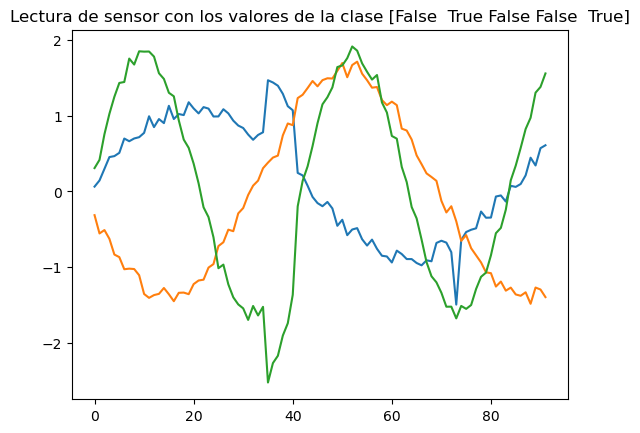

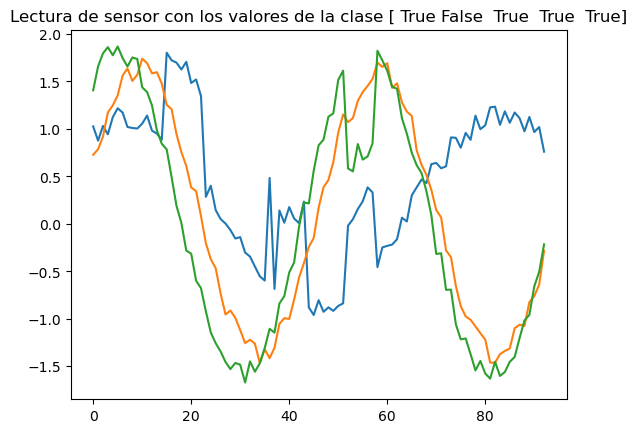

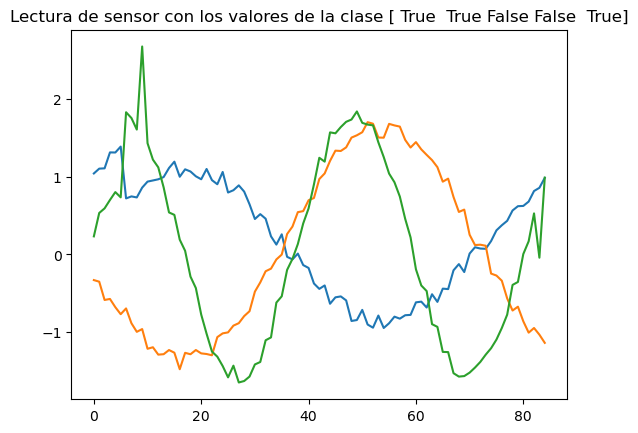

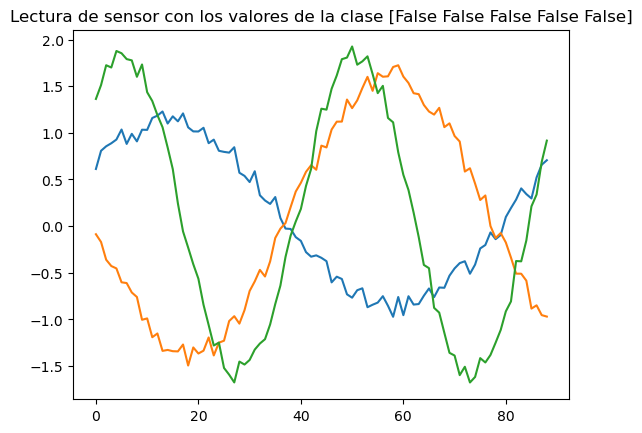

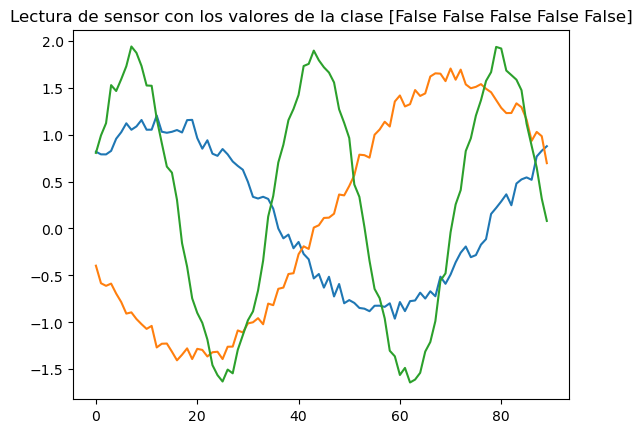

In [4]:
def sensor_plotter(sensor_data, error_class=None):

      if error_class is None:
            plt.title("Lectura de sensor")
      else:
            plt.title(f"Lectura de sensor con los valores de la clase {error_class}")
            
      # Visualizar los datos del sensor
      plt.plot(sensor_data)
      plt.show()

# Elegir aleatoriamente 5 lecturas de sensores
random_indices = random.sample(range(len(xl)), 5)
    
# Recorrer los índices y visualizar cada lectura de sensor
for index in random_indices:
      sensor_data = xl[index]
      error_class = yl[index]
      sensor_plotter(sensor_data, error_class)

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Describe los datos</strong>: tipo de funciones, diferentes tipos de errores que puedas identificar, etc...</p>
<p>

Los datos consisten en lecturas de sensores, que se almacenan como listas de valores de punto flotante en xl.
Las clases de error asociadas se almacenan como listas de valores booleanos en yl. Los valores booleanos indican probablemente si la lectura de sensor correspondiente se clasificó como normal (False) o defectuosa (True).
</p>
</div>

## 1.3 Estadísticos sobre los datos

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Realiza un estudio estadístico básico de los datos:</p>
  <ul>
    <li> Convierte los labels booleanos en numéricos <code>False -> 0.</code> y <code>True -> 1.</code>. </li>
    <li>Probabilidad de aparición de cada tipo de error. Haz un histograma para la clase con menor probabilidad de aparición.</li>
    <li>Longitud media, máxima y mínima de las lecturas de los sensores. Haz un histograma para las longitudes y determina que tipo de distribución genera las diferentes logitudes en las lecturas de los sensores.</li>
  </ul>
</div>

Probabilidad de error 0: 0.1783
Probabilidad de error 1: 0.2694
Probabilidad de error 2: 0.1019
Probabilidad de error 3: 0.3268
Probabilidad de error 4: 0.4582


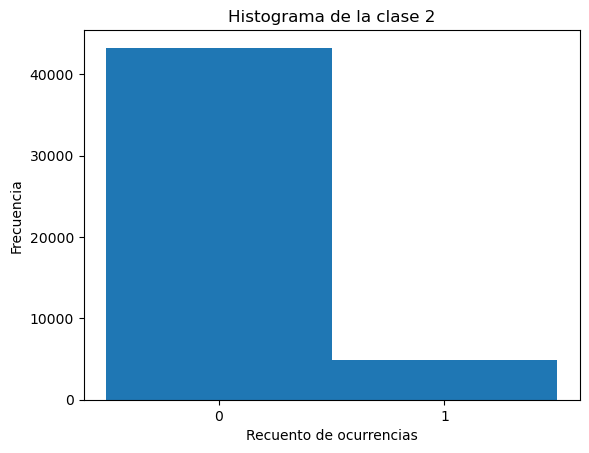

Longitud media: 89.50290
Longitud máxima: 101
Longitud mínima: 78


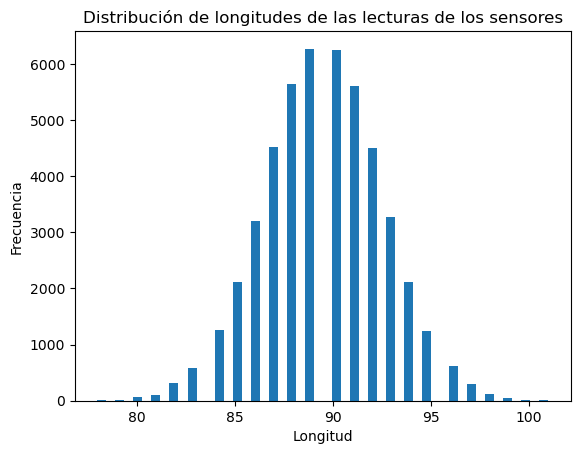

In [5]:
# Convertir los labels booleanos en numéricos
yl = [[int(val) for val in row] for row in yl]

# Calcular la probabilidad de aparición de cada tipo de error
probabilities = np.mean(yl, axis=0)

# Imprimir las probabilidades y las clases correspondientes
for i, p in enumerate(probabilities):
    print(f"Probabilidad de error {i}: {p:.4f}")

# Obtener la clase con menor probabilidad
min_class = np.argmin(probabilities)

# Filtrar las etiquetas para obtener solo la clase con menor probabilidad
min_class_labels = np.array([row[min_class] for row in yl])

# Trazar un histograma de los recuentos
plt.hist(min_class_labels, bins=[-0.5, 0.5, 1.5])
plt.xticks([0, 1])
plt.title(f"Histograma de la clase {min_class}")
plt.xlabel("Recuento de ocurrencias")
plt.ylabel("Frecuencia")
plt.show()

# Longitud media, máxima y mínima de las lecturas de los sensores
lengths = [len(x) for x in xl]
mean_length = np.mean(lengths)
max_length = np.max(lengths)
min_length = np.min(lengths)

print(f"Longitud media: {mean_length:.5f}")
print(f"Longitud máxima: {max_length}")
print(f"Longitud mínima: {min_length}")

# Histograma de las longitudes
plt.hist(lengths, bins=50)
plt.title("Distribución de longitudes de las lecturas de los sensores")
plt.xlabel("Longitud")
plt.ylabel("Frecuencia")
plt.show()

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comentarios:</strong></p>
<p>Los resultados muestran que las probabilidades de aparición de cada tipo de error son diferentes, lo que sugiere que algunas clases de errores pueden ser más difíciles de detectar que otras. En particular, la clase de error 2 tiene la probabilidad más baja, lo que significa que es la clase menos común. Este resultado podría tener implicaciones para la selección de estrategias de preprocesamiento o modelos de aprendizaje automático, ya que la clase menos común podría requerir una atención especial para ser detectada con precisión.

Los resultados muestran que las longitudes varían desde 78 hasta 101, con una longitud media de 89,5. Esto sugiere que podría ser necesario utilizar técnicas de normalización o truncamiento para asegurarse de que el modelo sea capaz de generalizar a diferentes longitudes de secuencia. Además, la distribución parece ser normal.</p>
</div>

## 1.4 Uniformizando la longitud de los datos

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Dado que las lecturas de los sensores tiene longitudes variables, necesitamos estandarizarlas. Para esta sección, hay varias opciones pero empezaremos por la más sencilla:</p>
  <ul>
    <li>Las lecturas con tiempos mayores a la media, las cortaremos.</li>
    <li>Las lecturas con tiempos menores a las medias, las completaremos con el valor médio de cada sensor.</li>
  </ul>
<p>Después de este proceso, elige un caso de tiempo mayor y uno menor y visualizalos usando la función <code>sensor_plotter</code>.</p>
</div>

Media redondeada: 90
Todas las lecturas tienen la misma longitud


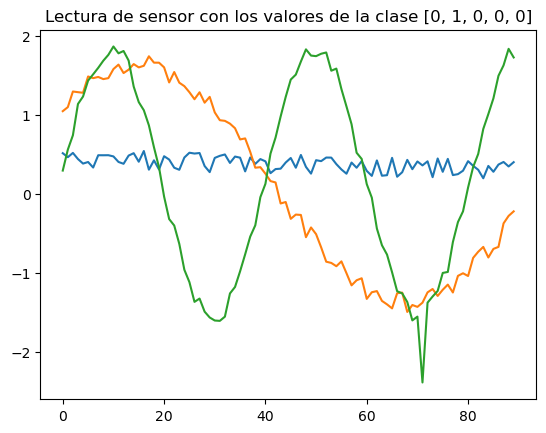

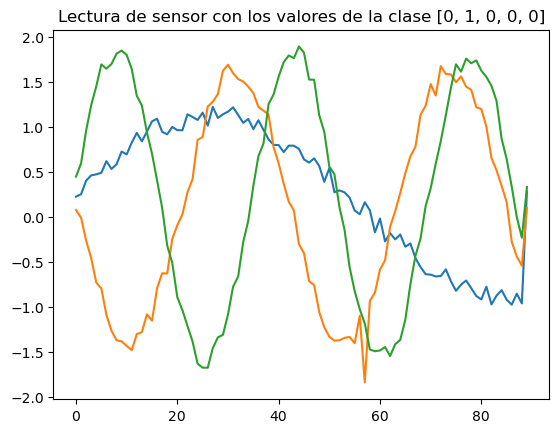

In [6]:
#Redondeamos la media al natural mas cercano
mean_length = round(mean_length)
print("Media redondeada:", mean_length)

# Recorrer las lecturas de los sensores y truncar aquellas que tengan una longitud mayor que la media
for i, d in enumerate(xl):
    if d.shape[0] > mean_length:
        xl[i] = d[:mean_length, :]
        longer_indices = i

# Recorrer las lecturas de los sensores y completar las que tengan una longitud menor que la media con el valor medio de cada sensor
for i, d in enumerate(xl):
    if d.shape[0] < mean_length:
        mean_values = np.mean(d, axis=0)
        num_values_to_add = mean_length - d.shape[0]
        values_to_add = np.tile(mean_values, (num_values_to_add, 1))
        xl[i] = np.concatenate((d, values_to_add), axis=0)
        shorter_indices = i

# Verificar que todas las lecturas tienen la misma longitud
lengths = [len(l) for l in xl[0]]
if all(l == lengths[0] for l in lengths):
    print("Todas las lecturas tienen la misma longitud")
else:
    print("Las lecturas aún tienen longitudes diferentes")

# Visualizar una lectura de un sensor con tiempo mayor que la media
longer_sensor_data = xl[longer_indices]
sensor_plotter(xl[longer_indices], yl[longer_indices])

# Visualizar una lectura de un sensor con tiempo menor que la media
shorter_sensor_data = xl[shorter_indices]
sensor_plotter(xl[shorter_indices], yl[shorter_indices])


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comenta que tipo de problemas puede conllevar este proceso</strong>. ¿Propondrías otro método para uniformizar los datos?</p>
<p>El método propuesto en este caso, que consiste en cortar las lecturas con tiempos mayores a la media y completar las lecturas con tiempos menores a la media con el valor medio de cada sensor, puede conllevar algunos problemas.

Por un lado, cortar las lecturas más largas puede hacer que se pierdan datos importantes, lo que puede afectar negativamente a los análisis que se realicen posteriormente. Por otro lado, completar las lecturas más cortas con el valor medio puede introducir ruido en los datos y hacer que se pierda información relevante.

Otro método que se podría utilizar para uniformizar los datos es el re-muestreo de los mismos. Con el re-muestreo se puede obtener una secuencia de valores a intervalos de tiempo uniformes, lo que facilita su análisis. Sin embargo, el re-muestreo también puede introducir cierto nivel de ruido en los datos.</p>
</div>

## 1.5 Data split para clasificación

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Antes de empezar con la construcción de un modelo de clasificación, realizaremos una partición (split) de los datos en 3 grupos:</p>
  <ul>
    <li> 80% para entrenamiento: <code>x_train</code></li>
    <li> 10% para validacion: <code>x_val</code></li>
    <li> 10% para testeo <code>x_test</code></li>
  </ul>
<p>y un <i>shuffle</i> de cada conjunto.</p>
</div>

In [7]:
# Obtener el número de elementos en la lista
n_samples = len(xl)

# Inicializar el array final auxiliar
data_array = np.empty((n_samples, 90, 3))

# Recorrer cada elemento de la lista y apilarlos en el array final auxiliar
for i, elemento in enumerate(xl):
    data_array[i] = elemento

# Verificar la forma del array final auxiliar

xl = data_array
yl = np.array(yl)
print("Dimensiones del array final:", xl.shape)
print("Dimensiones del array final:", yl.shape)

Dimensiones del array final: (48159, 90, 3)
Dimensiones del array final: (48159, 5)


In [8]:
# Calcular los índices para cada subconjunto
train_index = int(n_samples * 0.8)
val_index = int(n_samples * 0.9)

# Dividir los datos en los subconjuntos
x_train = xl[:train_index]
x_val = xl[train_index:val_index]
x_test = xl[val_index:]
y_train = yl[:train_index]
y_val = yl[train_index:val_index]
y_test = yl[val_index:]

# Imprimir las dimensiones de cada conjunto
print("Dimensiones de x_train:", np.shape(x_train))
print("Dimensiones de y_train:", np.shape(y_train))
print("Dimensiones de x_val:", np.shape(x_val))
print("Dimensiones de y_val:", np.shape(y_val))
print("Dimensiones de x_test:", np.shape(x_test))
print("Dimensiones de y_test:", np.shape(y_test))

Dimensiones de x_train: (38527, 90, 3)
Dimensiones de y_train: (38527, 5)
Dimensiones de x_val: (4816, 90, 3)
Dimensiones de y_val: (4816, 5)
Dimensiones de x_test: (4816, 90, 3)
Dimensiones de y_test: (4816, 5)


# 2. Clasificación (3 puntos)

El primer paso será definir las dimensiones de los datos de entrada en los modelos

In [10]:
# Definimos el número de sensores de los que disponemos y el número de clases (tipos de errores)

# Definir el número de sensores y el número de clases
n_sensors = xl.shape
n_classes = yl.shape[1]

# Verificar las dimensiones
print("Número de sensores: ", n_sensors)
print("Número de clases: ", n_classes)

Número de sensores:  (48159, 90, 3)
Número de clases:  5


## 2.1 Callbacks

Una vez tenemos los datos preparados y entendemos mejor el conjunto de datos del que disponemos, podemos empezar a testear diferentes arquitecturas para la clasificación de los tipos de errores. 

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> Primero, crearemos un callback propio para conocer el tiempo utilizado en el entrenamiento ya que lo usaremos también como métrica a la hora de escoger la arquitectura final de la red de clasificación.</p>
</div>

In [11]:
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback

class TimerCallback(Callback):
    def __init__(self):
        self.start_time = None
        self.epoch_times = []
        
    def on_train_begin(self, logs=None):
        self.start_time = time.time()
        
    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.start_time
        self.epoch_times.append(epoch_time)
        print(f"Época {epoch+1} - Tiempo transcurrido: {epoch_time:.2f} segundos")
        
    def on_train_end(self, logs=None):
        total_time = time.time() - self.start_time
        print(f"Entrenamiento completado en {total_time:.2f} segundos")
        print(f"Tiempo promedio por época: {sum(self.epoch_times) / len(self.epoch_times):.2f} segundos")
        
    def plot_epoch_times(self):
        fig, ax = plt.subplots()
        ax.plot(range(len(self.epoch_times)), self.epoch_times)
        ax.set_xlabel("Época")
        ax.set_ylabel("Tiempo (s)")
        ax.set_title("Historial de tiempo de época")
        plt.show()
        
    def get_total_time(self):
        return time.time() - self.start_time

Además, usaremos la siguiente clase para visualizar las métricas durante el _fit_ de los modelos:

In [12]:
#------------------------------#
#     NO TOCAR ESTA CLASE      #
#------------------------------#

class PlotLearning(Callback):
    """
    Callback para plotear las métricas durante el entrenamiento.
    """
    def __init__(self, showLR=False):
      self.showLR = showLR                   # podemos elegir si mostrar o no el plot del learning rate en cada epoch

    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        metric = [x for x in logs if ('val' not in x) and ('lr' not in x)]
        if self.showLR:
          metric.append('lr')
        
        f, axs = plt.subplots(1,len(metric),figsize=(10,4))
        clear_output(wait=True)
        for i,ax in enumerate(axs):
          ax.plot(range(1, epoch + 2), self.metrics[metric[i]],'o--',label=metric[i])
          try:
            ax.plot(range(1, epoch + 2), self.metrics['val_' + metric[i]], 'o--', label='val_' + metric[i])
          except:
            pass
          ax.set_xlabel('# epochs')
          ax.set_ylabel(metric[i])
          ax.legend()
          ax.grid()

        plt.tight_layout()
        plt.show()

## 2.2 SimpleRNN Layer

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> El primer paso será construir un modelo, <code>simpleRNN_model</code>, basado en un único _layer_ <code>SimpleRNN</code> para tener un primer modelo base con el que comparar:</p>
  <ul>
    <li><code>SimpleRNN</code> con <code>units = 128</code>.</li>
    <li>La capa final será una cada densa con tantos nodos como clases tenemos.</li>
  </ul>
<p>El output de la capa densa la interpretaremos como una probabilidad, por lo que es necesario escoger correctamente la función de activación y justificar su elección. Además, utilizaremos <code>Adam</code> como optimizador y la función de <i>loss</i> deberá ser la adecuada teniendo en cuenta la tarea que llevamos a cabo.</p>
</div>

**NOTA**: 
- Se recomienda, al final de la creación de cada modelo, utilizar la función `summary()` para comprobar la estructura de la red creada, así como el numero de parámetros que se deben entrenar. Se recomienda hacerlo en todos los ejercicios.

In [57]:
# Definir el modelo
simpleRNN_model = Sequential()
simpleRNN_model.add(SimpleRNN(units=128, input_shape=(None, 3)))
simpleRNN_model.add(Dense(n_classes, activation='sigmoid'))

# Compilar el modelo
simpleRNN_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])


In [58]:
# Mostramos el summary del modelo
simpleRNN_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 128)               16896     
                                                                 
 dense_3 (Dense)             (None, 5)                 645       
                                                                 
Total params: 17,541
Trainable params: 17,541
Non-trainable params: 0
_________________________________________________________________


#### Entrenamiento

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong>  Entrenaremos por 100 epochs con <code>batch_size = 256</code> y usando los siguientes callbacks:</p>
  <ul>
    <li>  TimerCallback (ver apartado 2.1)</li>
    <li>  PlotLearning (ver apartado 2.1)</li>
    <li>  EarlyStopping con una persistencia de 5 epochs</li>
    <li>  ReduceLROnPlateau con una persistencia de 5 epochs y monitorizando la <code>loss</code></li>
  </ul>
<p>Al finalizar el entreamiento:</p>
<ul>
    <li>  Realizar la evaluación del modelo y mostrar la <code>loss</code> y la <code>accuracy</code> final sobre los datos de test.</li>
    <li>  Realiza un plot del tiempo para cada epoch y calcula el tiempo total de entrenamiento con la información almacenada en el <code>TimerCallback</code> que has definido. </li>
  </ul>
</div>

**NOTAS**: 
- Se recomienda hacer una función que imprima esta gráfica para poder reutilizarla en próximos apartados.
- Se recomienda SIEMPRE guardar los modelos una vez entrenados, pero es muy importante si trabajáis con entornos como Colab que os cierra las sesiones.
- Los timepos los necesitaremos luego, por lo que puede ser una buena idea también guardar los resultados de tiempos para cada epoch.

In [59]:
# Definición de callbacks
timer_cb = TimerCallback()
plot_cb = PlotLearning()
earlystop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reducelr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)

callbacks = [timer_cb, plot_cb, earlystop_cb, reducelr_cb]

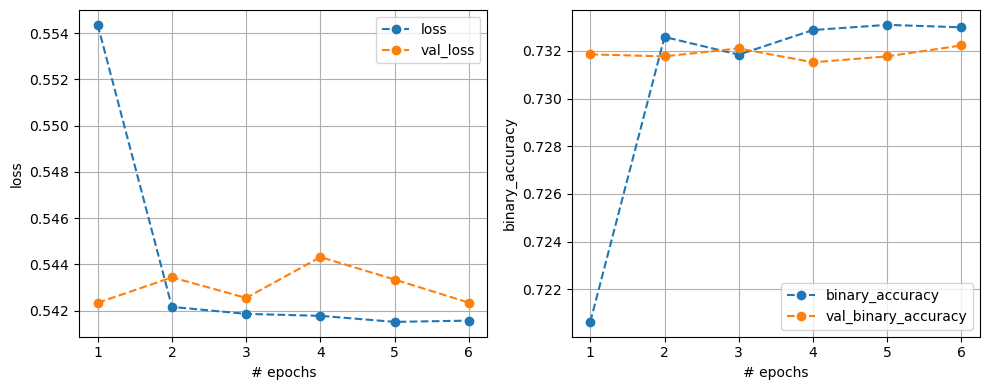

Entrenamiento completado en 55.31 segundos
Tiempo promedio por época: 32.64 segundos


In [60]:
# Entrenamiento del modelo
history = simpleRNN_model.fit(x_train, y_train, epochs=100, batch_size=256, 
                    validation_data=(x_val, y_val), verbose=0, callbacks=callbacks)

151/151 [==============================] - 1s 8ms/step - loss: 0.5395 - binary_accuracy: 0.7318
Loss en test: 0.5395011901855469
Precisión en test: 0.7318107485771179


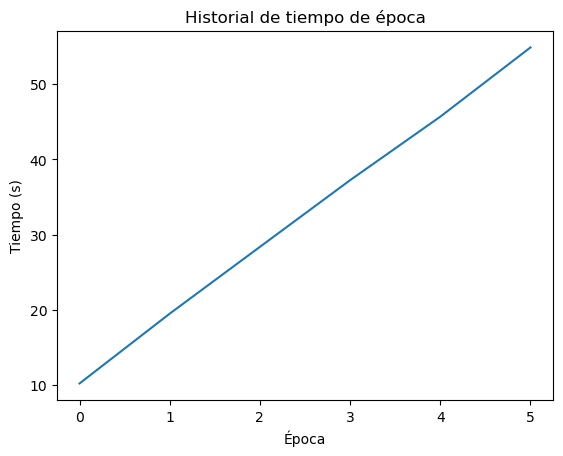

Tiempo total de entrenamiento: 88.45725178718567 segundos


In [62]:
# Evaluación del modelo
loss, acc = simpleRNN_model.evaluate(x_test, y_test)
print("Loss en test:", loss)
print("Precisión en test:", acc)

# Plot del tiempo por epoch
timer_cb.plot_epoch_times()

# Tiempo total de entrenamiento
print("Tiempo total de entrenamiento:", timer_cb.get_total_time(), "segundos")


In [64]:
# Guardar el modelo
simpleRNN_model.save('simpleRNN_model.h5')

## 2.3 GRU layer

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong>  En este apartado replicaremos el modelo anterior, pero ahora cambiando el layer <code>SimpleRNN</code> por un layer <code>GRU</code> para comparar el rendimiento y el tiempo de entrenamiento. En este caso utilizaremos 64 unidades en lugar de 128 para mantener el número de parámetros y el tiempo de entrenamiento bajos.</p>
<p>Comenta los resultados:</p>
<ul>
    <li>  ¿Mejora el rendimiento general?</li>
    <li>  ¿Aumenta el tiempo de entrenamiento? ¿Y el número de parámetros entrenables?</li>
    <li>  ¿Cúal funciona mejor? ¿Por qué crees que sucede esto?</li>
  </ul>
</div>

In [65]:
# Definir el modelo
def gru_model():
    model = Sequential()
    model.add(GRU(64, input_shape=(None, 3)))
    model.add(Dense(n_classes, activation='sigmoid'))
    return model

# Crear el modelo
simpleGRU_model =gru_model()

# Compilar el modelo
simpleGRU_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

# Imprimir un resumen del modelo
simpleGRU_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_6 (GRU)                 (None, 64)                13248     
                                                                 
 dense_4 (Dense)             (None, 5)                 325       
                                                                 
Total params: 13,573
Trainable params: 13,573
Non-trainable params: 0
_________________________________________________________________


In [66]:
# Definición de callbacks
timer_cb_simpleGRU = TimerCallback()
plot_cb_simpleGRU = PlotLearning()
earlystop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reducelr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
callbacks = [timer_cb_simpleGRU, plot_cb_simpleGRU, earlystop_cb, reducelr_cb]

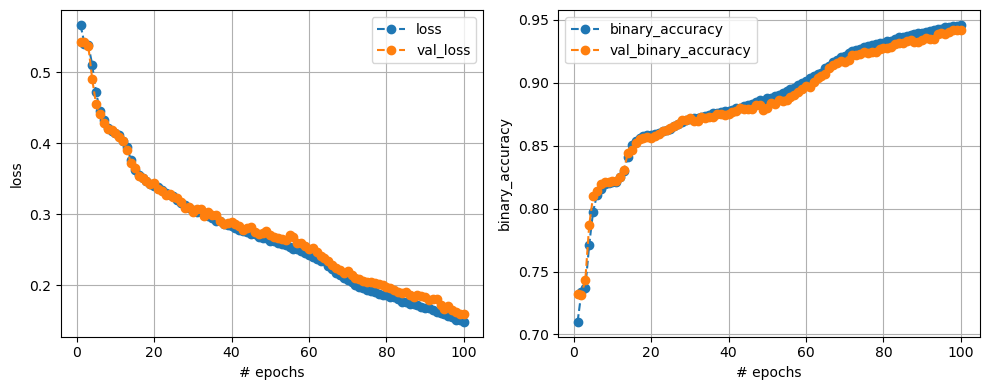

151/151 [==============================] - 2s 14ms/step - loss: 0.1484 - binary_accuracy: 0.9461 - val_loss: 0.1590 - val_binary_accuracy: 0.9423 - lr: 0.0010
Entrenamiento completado en 214.52 segundos
Tiempo promedio por época: 109.30 segundos


In [67]:
# entrenar el modelo
gru_history = simpleGRU_model.fit(x_train, y_train, batch_size=256, epochs=100, callbacks=callbacks, validation_data=(x_val, y_val))

151/151 [==============================] - 1s 4ms/step - loss: 0.1605 - binary_accuracy: 0.9411
Loss en test: 0.16045737266540527
Precisión en test: 0.9411129355430603


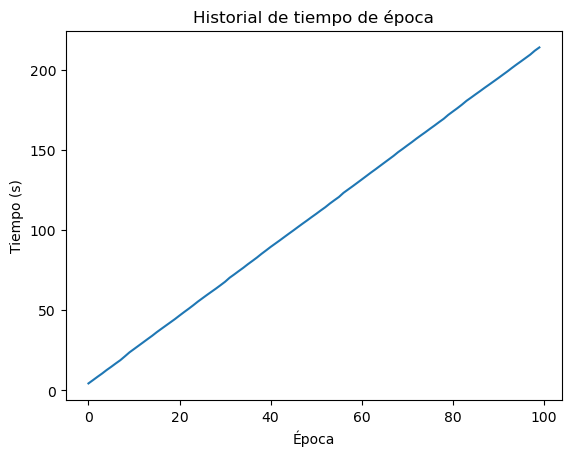

Tiempo total de entrenamiento: 264.58518409729004 segundos


In [68]:
# Evaluación del modelo
loss, acc = simpleGRU_model.evaluate(x_test, y_test)
print("Loss en test:", loss)
print("Precisión en test:", acc)

# Plot del tiempo por epoch
timer_cb_simpleGRU.plot_epoch_times()

# Tiempo total de entrenamiento
print("Tiempo total de entrenamiento:", timer_cb_simpleGRU.get_total_time(), "segundos")

In [69]:
# Guardar el modelo
simpleGRU_model.save('simpleGRU_model.h5')

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comentarios:</strong></p>
<p><strong>¿Mejora el rendimiento general?</strong>

En comparación con el primer modelo de la red neuronal simple (SimpleRNN), el segundo modelo de red neuronal recurrente (RNN) GRU muestra un mejor rendimiento general. El modelo GRU tiene una pérdida de validación y una precisión de validación más bajas que el modelo SimpleRNN, lo que indica una mejor capacidad para generalizar en datos nuevos y desconocidos. Además, la precisión de la evaluación del modelo GRU en el conjunto de datos de prueba es significativamente mayor que la del modelo SimpleRNN.

<strong>¿Aumenta el tiempo de entrenamiento? ¿Y el número de parámetros entrenables?</strong>

Sí, el modelo con GRU tardó un poco más en entrenarse que el modelo con SimpleRNN. A pesar de tener menos unidades, la complejidad de los cálculos en la capa GRU puede ser mayor que en la capa SimpleRNN.

En términos de parámetros entrenables, el modelo con GRU tiene menos parámetros que el modelo con SimpleRNN, ya que utiliza menos unidades en la capa recurrente.

<strong>¿Cúal funciona mejor? ¿Por qué crees que sucede esto?</strong>

En general, el modelo GRU funciona mejor que el modelo SimpleRNN debido a su capacidad para capturar patrones de secuencias más complejos y su capacidad para evitar el problema de desvanecimiento de gradientes que se encuentra en modelos RNN más simples. La arquitectura GRU puede aprender a "olvidar" o "recordar" información en una secuencia en función de su relevancia, lo que puede resultar en una mejor captura de patrones de secuencias a largo plazo.</p>
</div>

### 2.3.1 Incrementando la capacidad de nuestro modelo

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong>En esta sección intentaremos incrementar la capacidad de nuestro modelo y, para ello, en lugar de añadir unidades, aumentaremos la profundidad, sumando otra capa GRU. Esta nueva capa recibirá la sequencia de la capa anterior y tendrá la mitad de unidades.</p>
    <p>Comenta los resultados de rendimiento en <i>accuracy</i> y en tiempo.</p>
</div>

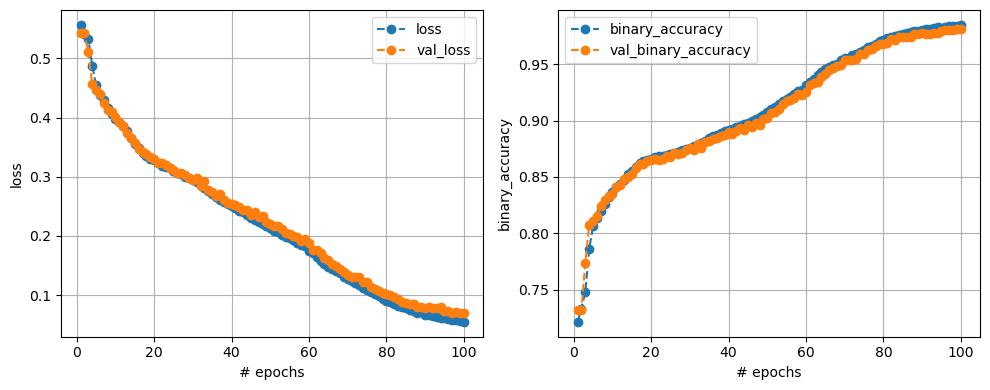

151/151 [==============================] - 3s 20ms/step - loss: 0.0549 - binary_accuracy: 0.9847 - val_loss: 0.0692 - val_binary_accuracy: 0.9807 - lr: 0.0010
Entrenamiento completado en 313.01 segundos
Tiempo promedio por época: 160.41 segundos


In [70]:
# Definir el modelo
gru_model = Sequential()

# Agregar la primera capa GRU con 64 unidades
gru_model.add(GRU(units=64, input_shape=(None, 3), return_sequences=True))

# Agregar la segunda capa GRU con 32 unidades
gru_model.add(GRU(units=32))

# Agregar la capa densa con tantos nodos como clases tenemos, y utilizar la función de activación softmax para obtener una distribución de probabilidad
gru_model.add(Dense(n_classes, activation='sigmoid'))

# compilar el modelo
gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

# Definición de callbacks
timer_cb = TimerCallback()
plot_cb = PlotLearning()
earlystop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reducelr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
callbacks = [timer_cb, plot_cb, earlystop_cb, reducelr_cb]

# entrenar el modelo
gru_history = gru_model.fit(x_train, y_train, batch_size=256, epochs=100, callbacks=callbacks, validation_data=(x_val, y_val))

In [71]:
# Imprimir un resumen del modelo
gru_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_7 (GRU)                 (None, None, 64)          13248     
                                                                 
 gru_8 (GRU)                 (None, 32)                9408      
                                                                 
 dense_5 (Dense)             (None, 5)                 165       
                                                                 
Total params: 22,821
Trainable params: 22,821
Non-trainable params: 0
_________________________________________________________________


151/151 [==============================] - 1s 5ms/step - loss: 0.0703 - binary_accuracy: 0.9799
Loss en test: 0.07033465057611465
Precisión en test: 0.9798585772514343


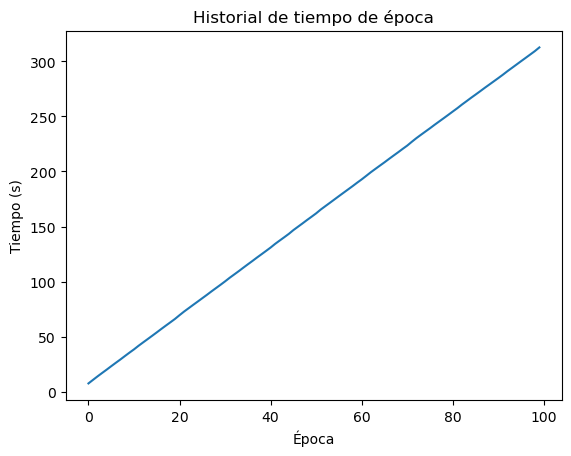

Tiempo total de entrenamiento: 326.91447162628174 segundos


In [72]:
# Evaluación del modelo
loss, acc = gru_model.evaluate(x_test, y_test)
print("Loss en test:", loss)
print("Precisión en test:", acc)

# Plot del tiempo por epoch
timer_cb.plot_epoch_times()

# Tiempo total de entrenamiento
print("Tiempo total de entrenamiento:", timer_cb.get_total_time(), "segundos")

In [73]:
# Guardar el modelo
gru_model.save('gru_model.h5')

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comentarios:</strong></p>
<p>
El modelo de red neuronal recurrente GRU con dos capas (Sequential_6) tiene un rendimiento aún mejor que el modelo GRU anterior. El modelo GRU con dos capas logró una precisión en el conjunto de datos de prueba del 97,99%, lo que es significativamente mayor que las precisiónes de los modelos GRU y SimpleRNN anteriores.

Sin embargo, el modelo de red neuronal recurrente GRU con dos capas tiene un mayor número de parámetros entrenables que los modelos GRU y SimpleRNN anteriores, lo que resulta en un tiempo de entrenamiento más largo. A medida que se agregan más capas y neuronas, el número de parámetros en la red aumenta exponencialmente y, por lo tanto, aumenta el tiempo de entrenamiento.

En general, el modelo de red neuronal recurrente GRU con dos capas logró la mejor precisión en el conjunto de datos de prueba, pero a costa de un mayor tiempo de entrenamiento debido a la mayor cantidad de parámetros entrenables.</p>
</div>

## 2.4 LSTM vs. GRU

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong>   
Sabemos que otro tipo de capa utilizada para las series temporales son las LSTM. En esta sección probaremos esta arquitectura y la compararemos con la anterior, para ver si es posible mejorar en rendimiento (<code>accuracy</code>) y/o en el tiempo de entrenamiento. Para ello, utilizaremos las mismas unidades en 2 capas de LSTM y entrenaremos de la misma forma la red. </p>
</div>

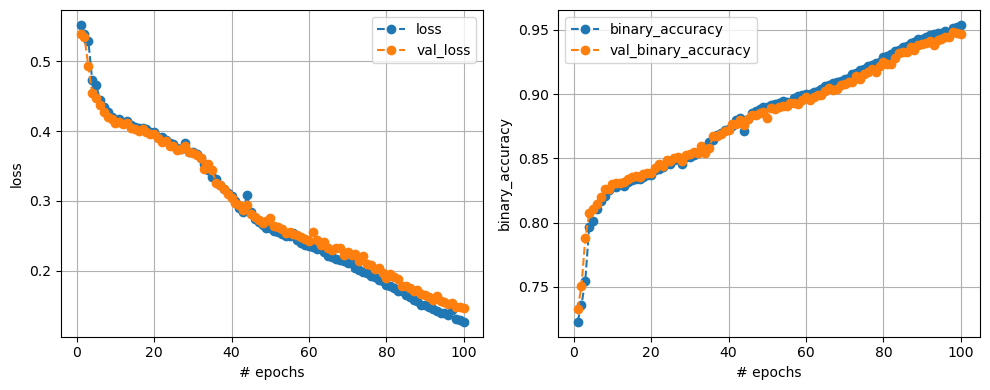

151/151 [==============================] - 3s 21ms/step - loss: 0.1270 - binary_accuracy: 0.9539 - val_loss: 0.1464 - val_binary_accuracy: 0.9470 - lr: 0.0010
Entrenamiento completado en 321.81 segundos
Tiempo promedio por época: 164.16 segundos


In [74]:
# definir el modelo
LSTM_model = Sequential()

# agregar una capa LSTM con 64 unidades
LSTM_model.add(LSTM(units=64, input_shape=(None, 3), return_sequences=True))

# agregar otra capa LSTM con 32 unidades y la mitad de las secuencias
LSTM_model.add(LSTM(units=32))

# agregar una capa densa con tantos nodos como clases tenemos, y utilizar la función de activación softmax para obtener una distribución de probabilidad
LSTM_model.add(Dense(n_classes, activation='sigmoid'))

# compilar el modelo
LSTM_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

# definir los callbacks
timer_cb = TimerCallback()
plot_learning = PlotLearning()
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5)

# entrenar el modelo
LSTM_history = LSTM_model.fit(x_train, y_train, epochs=100, batch_size=256, 
                              validation_data=(x_test, y_test), 
                              callbacks=[timer_cb, plot_learning, early_stopping, reduce_lr])

In [75]:
# imprimir un resumen del modelo
LSTM_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 64)          17408     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_6 (Dense)             (None, 5)                 165       
                                                                 
Total params: 29,989
Trainable params: 29,989
Non-trainable params: 0
_________________________________________________________________


151/151 [==============================] - 1s 5ms/step - loss: 0.1464 - binary_accuracy: 0.9470
Loss en test: 0.1463746577501297
Precisión en test: 0.9470100402832031


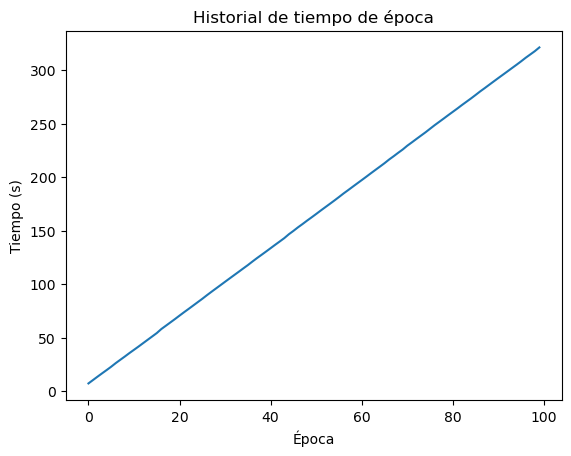

Tiempo total de entrenamiento: 323.39914536476135 segundos


In [76]:
# Evaluación del modelo
loss, acc = LSTM_model.evaluate(x_test, y_test)
print("Loss en test:", loss)
print("Precisión en test:", acc)

# Plot del tiempo por epoch
timer_cb.plot_epoch_times()

# Tiempo total de entrenamiento
print("Tiempo total de entrenamiento:", timer_cb.get_total_time(), "segundos")

In [77]:
# Guardar el modelo
LSTM_model.save('LSTM_model.h5')

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comentarios:</strong></p>
<p>
El modelo de red neuronal recurrente LSTM con dos capas tiene una precisión ligeramente inferior en el conjunto de datos de prueba en comparación con el modelo de red neuronal recurrente GRU con dos capas. La precisión del modelo LSTM en el conjunto de datos de prueba es del 94.70%, mientras que la precisión del modelo GRU es del 97,99%.

El modelo LSTM con dos capas también tiene un mayor número de parámetros entrenables que el modelo GRU con dos capas, lo que resulta en un tiempo de entrenamiento más largo. El modelo LSTM con dos capas tiene 29,989 parámetros entrenables, mientras que el modelo GRU con dos capas tiene 22,821 parámetros entrenables.

En general, el modelo de red neuronal recurrente GRU con dos capas parece ser la mejor opción en términos de precisión y tiempo de entrenamiento, en comparación con los modelos SimpleRNN, GRU y LSTM de dos capas.</p>
</div>

# 3. Elección del mejor modelo y *fine tuning* (2 puntos)

En el apartado anterior ya hemos probado varios tipos de modelos diferentes. Ahora, basados en el rendimiento, complejidad (número de parámetros) y tiempo de entrenamiento, debemos escoger el tipo de modelo que mejor se adecua a nuestro problema. 

## 3.1 Comparación de modelos

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]</strong>: Realiza y responde las siguientes cuestiones:</p>
  <ul>
    <li>Haz una tabla comparativa para todos los modelos y arquitecturas usadas comparando el rendimiento, el número de parámetros y el tiempo por época (time/epoch)</li>
    <li>Justifica la elección de un modelo</li>
  </ul>
</div>

<table ><tr><th> Modelo <th><th> Accuracy <th><th> Nº de parámetros <th><th> Tiempo <tr><tr>
<tr><td> SimpleRNN <td><td> 73.18% <td><td> 17,541 <td><td>  32.64 <td><tr>
<tr><td> GRU (1 capa) <td><td>  94.11% <td><td> 13,573 <td><td>  109.30 <td><tr>
<tr><td> GRU (2 capas) <td><td> 97.99% <td><td> 22,821 <td><td>  172.46 <td><tr>
<tr><td> LSTM (2 capas) <td><td> 94.70% <td><td> 29,989 <td><td>  173.46 <td><tr><table>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comentarios:</strong></p>
<p>
Según los resultados, el modelo GRU de 2 capas es el que mejor precisión tiene en el conjunto de datos de prueba, con un valor del 97,99%. Además, aunque tiene más parámetros entrenables y un tiempo de entrenamiento más largo que el modelo GRU de 1 capa, sigue siendo más rápido que el modelo LSTM de 2 capas.

Por lo tanto, en base a la precisión y el tiempo de entrenamiento, el modelo GRU de 2 capas es la mejor opción.</p>
</div>

## 3.2 *Fine Tuning* de parámetros para el modelo elegido

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pt.]:</strong>  Para realizar una elección de parámetros que optimize los resultados utilizaremos la librería <code>keras-tuner</code>. El primer paso con una librería nueva es consultar la documentación y familiarizarse con ejemplos básicos.</p>
<p>Los parámetros que eligiremos para el ajuste son:</p>
  <ul>
    <li><strong>Unidades de la primera capa</strong>. Variarán entre 16 y 64 con steps de 16.</li>
    <li>Añadiremos <strong>dropout en la segunda capa</strong> y los valores serán: 0, 0.1, 0.25 y 0.7 </li>
    <li><strong>Learning rate</strong> que podrá tomar los siguientes valores: 1e-2, 5e-3 y 1e-3</li>
  </ul>
<p>Finalmente, usaremos el método de <code>Hyperband</code> cuyo objetivo será optimizar la <i>accuracy</i> de validación.</p>
</div>

In [19]:
#------------------------------#
#    INSTALAMOS KERAS-TUNER    #
#------------------------------#

!pip install -q -U keras-tuner
import keras_tuner as kt
from kerastuner.tuners import Hyperband
from kerastuner import HyperModel

In [23]:
# Crear una función para definir el modelo
def model_builder(hp):
    model = Sequential()
    
    # Definir los hiperparámetros a ajustar
    units = hp.Choice('units', values=[16, 32, 48, 64])
    dropout_rate = hp.Choice('dropout_rate', values=[0.0, 0.1, 0.25, 0.7])
    learning_rate = hp.Choice('learning_rate', values=[1e-2, 5e-3, 1e-3])
    
    # Agregar la primera capa GRU
    model.add(GRU(units=units, input_shape=(None, 3), return_sequences=True))
    
    # Agregar la segunda capa GRU con dropout
    model.add(GRU(units=32))
    model.add(Dropout(dropout_rate))
    
    # Agregar la capa densa con la función de activación softmax
    model.add(Dense(n_classes, activation='sigmoid'))
    
    # Compilar el modelo con los hiperparámetros definidos
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['binary_accuracy'])
    
    return model

In [24]:
tuner = kt.Hyperband(model_builder,
                     objective='binary_accuracy',
                     max_epochs=100, 
                     executions_per_trial=3)

tuner.search(x_train, y_train, epochs=10, batch_size=256, validation_data=(x_val, y_val))

Trial 47 Complete [00h 00m 39s]
binary_accuracy: 0.7833243608474731

Best binary_accuracy So Far: 0.8330694039662679
Total elapsed time: 00h 28m 09s


## 3.3 Entrenamiento del modelo con los hiperparámetros tuneados

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong>Tal como hicimos en la sección 2 con otro modelos, entrena el modelo final para la clasificación durante 100 epochs usando los parámetros obtenidos en el apartado anterior, <code>EarlyStoping</code> con una <i>patience</i> de 5 epochs, pero ahora sin el callback para reducir el <i>learning rate</i>.</p>
<p>Calcula el <i>accuracy</i> sobre el grupo de test y el tiempo total de entrenamiento.</p>
</div>

In [28]:
def build_model(hp):
    # Crear el modelo
    model = Sequential()
    
    # Agregar la capa GRU con el número de unidades óptimo según la búsqueda de hiperparámetros
    model.add(GRU(units=hp.get('units'), input_shape=(None, 3), return_sequences=True))
    
    # Agregar la capa GRU con el número de unidades óptimo según la búsqueda de hiperparámetros
    model.add(GRU(units=32))
    model.add(layers.Dropout(hp.get('dropout_rate')))
    # Agregar la capa densa con el número de clases y la función de activación 'sigmoid'
    model.add(Dense(units=n_classes, activation='sigmoid'))
    
    # Compilar el modelo con el optimizador Adam, la pérdida 'binary_crossentropy' y la métrica de accuracy
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.get('learning_rate')),
                  loss='binary_crossentropy',
                  metrics=['binary_accuracy'])
    
    return model

In [29]:
# Obtener los hiperparámetros óptimos
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Crear el modelo con los hiperparámetros óptimos
gru_model_hp = build_model(best_hps)

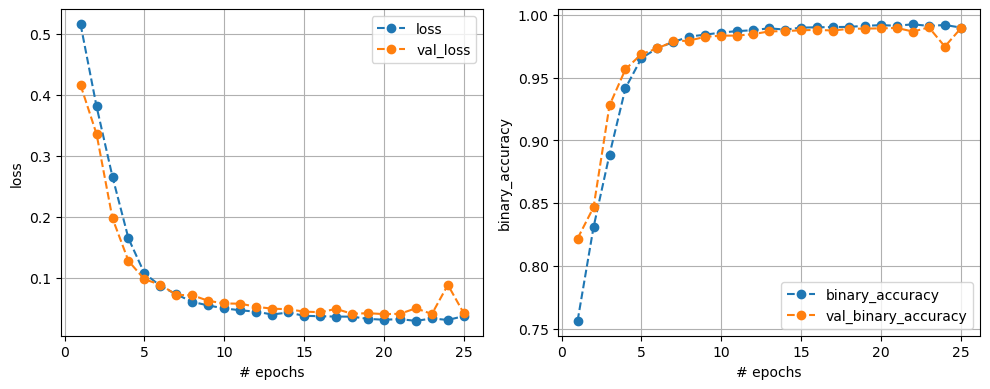

151/151 [==============================] - 3s 20ms/step - loss: 0.0380 - binary_accuracy: 0.9898 - val_loss: 0.0426 - val_binary_accuracy: 0.9892
Entrenamiento completado en 81.65 segundos
Tiempo promedio por época: 44.27 segundos


In [30]:
# Definición de callbacks
timer_cb = TimerCallback()
plot_cb = PlotLearning()
earlystop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [timer_cb, earlystop_cb,plot_cb]

# Entrenar el modelo
history = gru_model_hp.fit(x_train, y_train, batch_size=256, epochs=100, callbacks=callbacks, validation_data=(x_val, y_val))

151/151 [==============================] - 1s 6ms/step - loss: 0.0421 - binary_accuracy: 0.9894
Loss en test: 0.04206313192844391
Precisión en test: 0.989410400390625


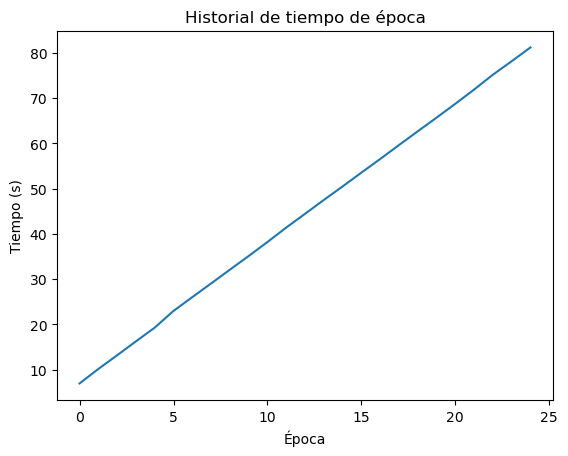

Tiempo total de entrenamiento: 146.09525871276855 segundos


In [31]:
# Evaluación del modelo
loss, acc = gru_model_hp.evaluate(x_test, y_test)
print("Loss en test:", loss)
print("Precisión en test:", acc)

# Plot del tiempo por epoch
timer_cb.plot_epoch_times()

# Tiempo total de entrenamiento
print("Tiempo total de entrenamiento:", timer_cb.get_total_time(), "segundos")

In [32]:
# Guardar el modelo
gru_model_hp.save('gru_model_hp.h5')

# 4. Localización de los errores (2 puntos)

## 4.1 Definiendo un nuevo modelo para la localización de los errores

Para encontrar cuándo ocurre un error en la lectura de un sensor, una secuencia determinada se dividirá en segmentos y la clasificación se realizará en cada segmento individualmente. Para ello, hay que definir un nuevo modelo que divida la señal de entrada y estas partes se le pasarán al siguiente _layer_ donde se usará el clasificador que ya hemos entrenado anteriormente.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1,5 pts.]:</strong>  Definir un nuevo modelo que constará de las siguientes capas (layers): </p>
  <ul>
    <li>  <code>Reshape</code> para cortar la entrada en sub-secuencias de 10 </li>
    <li>  Una capa con el clasificador anterior <code>best_model</code></li>
    <li>  Una capa final que nos permita obtener el máximo de las capas anteriores y poder comparar con los datos de entrenamiento</li>
  </ul>
<p> Entrena este modelo por 100 epochs usando, como siempre, EarlyStoping. Comenta los resultados y si realmente tiene sentido volver a entrenar con los mismos datos <code>x_train</code> de los que disponemos.</p>
</div>

In [33]:
# Definir la entrada
input_shape = (None, 3)
inputs = layers.Input(shape=input_shape)

# Reshape para cortar la entrada en sub-secuencias de 10
reshaped = layers.Reshape((-1, 10, 3))(inputs)

# Capa con el clasificador anterior best_model
error_detector = layers.TimeDistributed(gru_model_hp)(reshaped)

# Capa para obtener el máximo de las capas anteriores
max_pool = layers.GlobalMaxPooling1D()(error_detector)

# Definir el modelo
error_model = keras.models.Model(inputs=inputs, outputs=max_pool)


In [37]:
# Compilar el modelo
error_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

In [38]:
# Definición de callbacks
timer_cb = TimerCallback()
plot_cb = PlotLearning()
earlystop_cb = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [timer_cb, plot_cb, earlystop_cb]

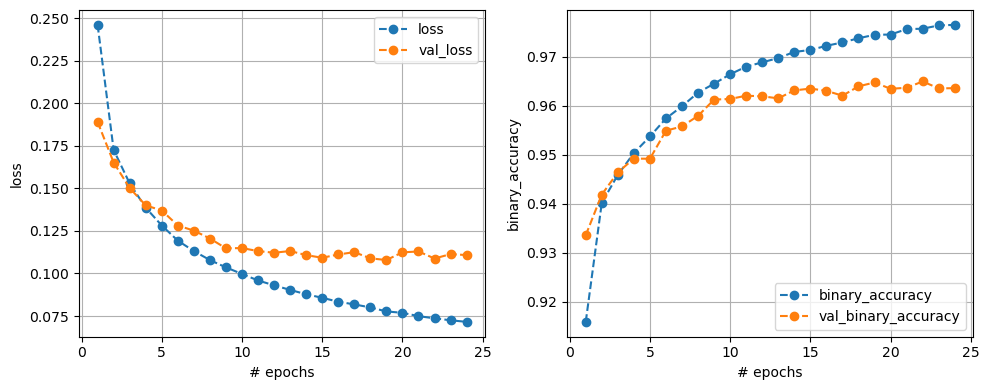

1204/1204 [==============================] - 8s 7ms/step - loss: 0.0716 - binary_accuracy: 0.9765 - val_loss: 0.1108 - val_binary_accuracy: 0.9636
Entrenamiento completado en 211.28 segundos
Tiempo promedio por época: 113.10 segundos


In [39]:
# Entrenar el modelo
history = error_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=100, callbacks=callbacks)

In [40]:
# imprimir un resumen del modelo
error_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 3)]         0         
                                                                 
 reshape (Reshape)           (None, None, 10, 3)       0         
                                                                 
 time_distributed (TimeDistr  (None, None, 5)          22821     
 ibuted)                                                         
                                                                 
 global_max_pooling1d (Globa  (None, 5)                0         
 lMaxPooling1D)                                                  
                                                                 
Total params: 22,821
Trainable params: 22,821
Non-trainable params: 0
_________________________________________________________________


151/151 [==============================] - 1s 4ms/step - loss: 0.1092 - binary_accuracy: 0.9631
Loss en test: 0.1091773584485054
Precisión en test: 0.9630813598632812


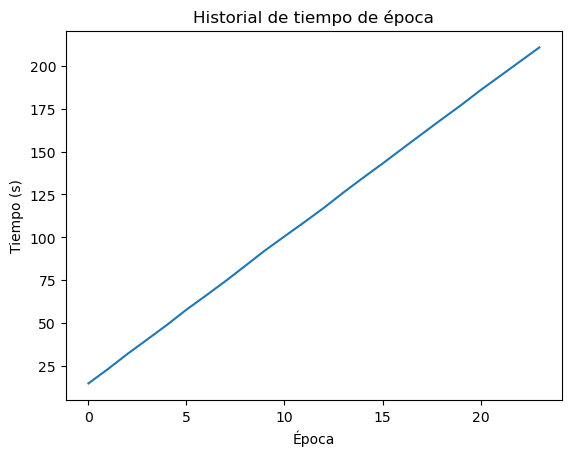

Tiempo total de entrenamiento: 218.58468413352966 segundos


In [41]:
# Evaluación del modelo
loss, acc = error_model.evaluate(x_test, y_test)
print("Loss en test:", loss)
print("Precisión en test:", acc)

# Plot del tiempo por epoch
timer_cb.plot_epoch_times()

# Tiempo total de entrenamiento
print("Tiempo total de entrenamiento:", timer_cb.get_total_time(), "segundos")

In [42]:
# Guardar el modelo
error_model.save('error_model.h5')

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comenta, además, que efectos tiene en la localización el hecho de hacer un reshape para tener N=9 sub-secuencias. Si hubiéramos elegido N=2, 5 o 18, ¿qué cambiaría? </strong></p>
<p>Al hacer un Reshape en el modelo, se divide la secuencia de entrada en sub-secuencias de un tamaño fijo. En el caso de que se elijan N=9 sub-secuencias, se corta la secuencia de entrada en 9 partes iguales, cada una con 10 valores.

El número de sub-secuencias elegido (N) afecta la cantidad de información que se pierde o se retiene. Si se eligen más sub-secuencias, se retiene más información, pero se aumenta el costo computacional y la cantidad de parámetros del modelo. Si se eligen menos sub-secuencias, se pierde más información, pero el modelo es más ligero y más fácil de entrenar.

En el caso de haber elegido N=2 sub-secuencias, se habría dividido la secuencia de entrada en dos partes iguales, cada una con 45 valores. Esto podría haber resultado en la pérdida de información importante si la secuencia de entrada fuera muy larga y se cortara en partes muy grandes.

Por otro lado, si se hubieran elegido N=5 sub-secuencias, se habría dividido la secuencia de entrada en cinco partes iguales, cada una con 18 valores. Esto podría haber resultado en una pérdida moderada de información, pero el modelo aún podría capturar patrones importantes.

Si se hubieran elegido N=18 sub-secuencias, se habría dividido la secuencia de entrada en partes muy pequeñas, cada una con 5 valores. Esto podría haber resultado en una pérdida significativa de información importante y habría sido difícil para el modelo capturar patrones relevantes en la secuencia de entrada.

En general, la elección de la cantidad de sub-secuencias depende del tamaño de la secuencia de entrada y de la complejidad del patrón que se quiere capturar. Por lo tanto, es importante ajustar el modelo a la tarea específica y evaluar el rendimiento del modelo en datos de prueba para determinar si se ha perdido información importante o si se ha agregado demasiado ruido en la secuencia de entrada.</p>
</div>

## 4.2 Modelo de localización de errores

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [0,5 pts.]:</strong> El modelo anterior devuelve predicciones para la secuencia completa, pero para poder localizar los errores necesitaremos las predicciones para cada sub-secuencia y, por lo tanto, definiremos un nuevo modelo, <code>loc_model</code>, igual al anterior, pero obviando el último layer.</p>
<p>Explica el resultado obtenido usando un dato de test como ejemplo.</p>
</div>

In [43]:
# Crear Local Model
local_model = Model(inputs = error_model.layers[0].input, outputs = error_model.layers[-2].output)

# Hacer predicciones en los datos de prueba utilizando el modelo local_model
y_pred = local_model.predict(x_test)

index = np.random.randint(len(x_test))
y_real = y_test[index]

#Lista de errores detectados
detectados = []

print("\n\nErrores detectados en cada lectura predecida:")
for fila in y_pred[index]:
    print(np.round(fila))
    for i in range(len(fila)):
            element_pred = np.round(fila[i])
            if (element_pred == 1.):
                if i+1 not in detectados:
                    # agregar el elemento a la lista
                    detectados.append(i+1)



print("\nErrores Reales:")
print(y_real)

print(f'\nLos sensores con errores predecidos son: {sorted(detectados)} \n(sabiendo que los sensores van desde del 1 al 5)')


151/151 [==============================] - 1s 2ms/step


Errores detectados en cada lectura predecida:
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]

Errores Reales:
[0 0 0 1 1]

Los sensores con errores predecidos son: [4, 5] 
(sabiendo que los sensores van desde del 1 al 5)


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comentarios:</strong></p>
<p>Como se puede ver, la salida devuelve 9 subsecuencias donde el sistema va prediciendo la cantidad de errores en esas subsecuencias. En el ejemplo mostrado los sensores que tienen valores positivos son el 4 y el 5, mientras que los distintos sensores con valores positivos en las predicciones son también el 4 y el 5, estos sensores son reconocidos en la tercera y sexta subsecuencia, mientras que en las otras no detectan errores.</p>
</div>

## 5. Visualización de los errores  (1 punto)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<p><strong>Ejercicio [1 pt.]:</strong> Diseña una función que reciba una lectura de los sensores y su label, y que devuelva una gráfica con:</p>
    <ul>
    <li>  La lectura de los sensores.</li>
    <li>  Una banda vertical en la sub-secuencia donde se encuentra cada error. Habrá tantas bandas verticales como errores existan en la lectura.</li>
    <li>  Las bandas indicando errores deberán tener un color asociado a cada tipo de error y el <code>alpha</code> usado para pintar esa región será proporcional a la confianza en la clasificación de ese error.</li>
  </ul>
  <p>Además, informa de los errores detectados y los reales por pantalla. Usa esta función para visualizar 10 lecturas diferentes. ¿Qué color hace referencia al error producido por el paso del metro?</p>
</div>

In [44]:
# Puedes usar estos colores para cada identificar los diferentes tipos de errores
color_errores = {1: 'tab:red', 2: 'tab:purple', 3: 'tab:brown', 4: 'tab:cyan', 5: 'tab:olive'}

In [53]:
def plot_sensor_data_with_errors(sensor_data, sensor_label):
    
    # Creamos la gráfica sensores
    plt.figure(figsize=(15, 5))
    plt.plot( sensor_data[:, 0], label='Sensor 1')
    plt.plot(sensor_data[:, 1], label='Sensor 2')
    plt.plot(sensor_data[:, 2], label='Sensor 3')
    
    # Obtenemos las predicciones del modelo
    predicted = local_model.predict(sensor_data.reshape(1, -1, 3))
       
    # Obtenemos las predicciones reales del modelo
    real = sensor_label

    #Dibujamos el tamaño de cada lectura
    for i in range(0, len(sensor_data)+10, 10):
        plt.axvspan(i-.01, i+.01, alpha=1, color='k')
        
    # Ajustamos los parametros que controla ventana de lecturas
    aux = ventana = 2
    incremento = 10
    
    # Lista de errores
    errores_detectados = []
    
    #Definimos el umbral de confianza para las clasificaciones (correspondiente a accurracy del error_model)
    confianza_minima = acc


    #Obtenemos la prediccion de cada lectura
    for fila in predicted:
        print("\n\nErrores detectados:")
        for element in fila:
            print(np.round(element))
            for i in range(len(element)):
                if(ventana > 90):
                    ventana = 88
                element_pred = np.round(element[i])
                if (element_pred == 1.):
                    # verificar si el elemento ya está en la lista
                    if i+1 not in errores_detectados:
                        # agregar el elemento a la lista
                        errores_detectados.append(i+1)
                    alpha = (element[i]-confianza_minima)/(1-confianza_minima)
                    if alpha < 0:
                        alpha = 0
                    plt.axvspan(ventana, ventana+1, alpha=alpha, color=color_errores[i+1])
                    ventana = ventana + 4

            aux = aux + incremento
            ventana = aux
            if(ventana > 90):
                ventana = 88
    print(f'\nLos sensores con errores predecidos son: {sorted(errores_detectados)}')
                
    # Añadimos las etiquetas a la gráfica
    plt.legend()
    plt.xlabel('Tiempo')
    plt.ylabel('Lectura de los sensores')
    plt.title(f'Lectura de sensores con errores (error real: {sensor_label})')
    plt.show()

1/1 [==============================] - 0s 21ms/step


Errores detectados:
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 1. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0.]

Los sensores con errores predecidos son: [2, 5]


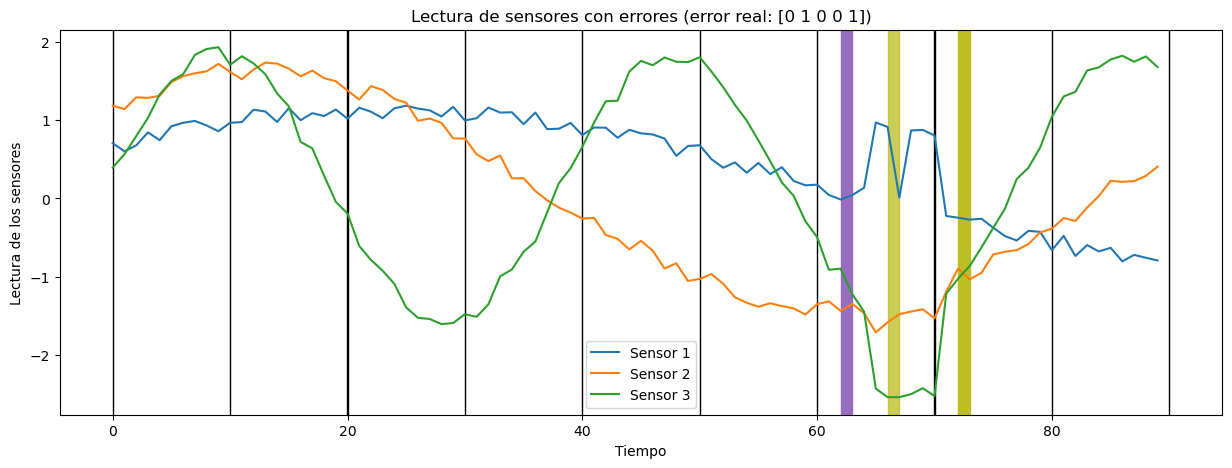

1/1 [==============================] - 0s 21ms/step


Errores detectados:
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]

Los sensores con errores predecidos son: []


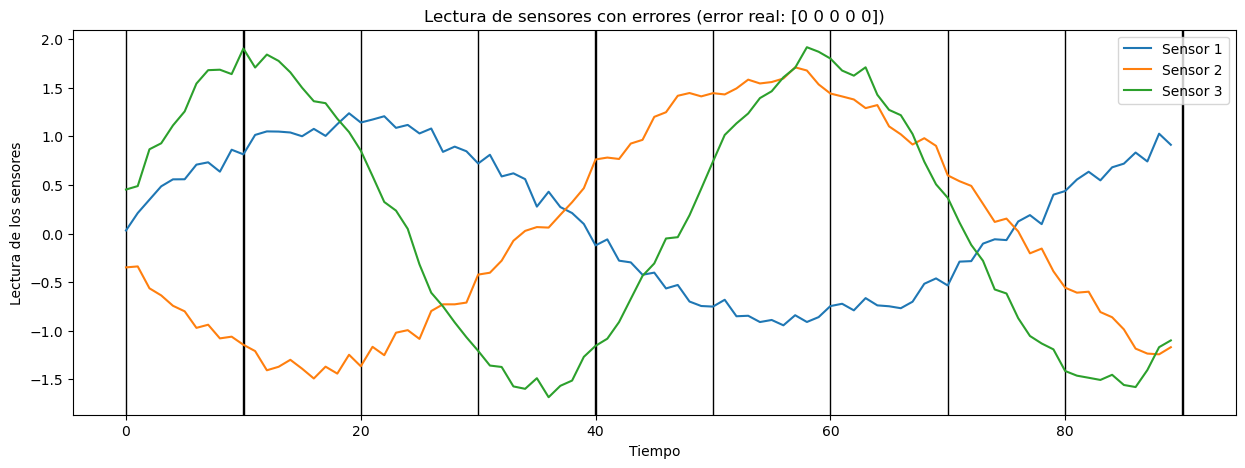

1/1 [==============================] - 0s 21ms/step


Errores detectados:
[1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]

Los sensores con errores predecidos son: [1]


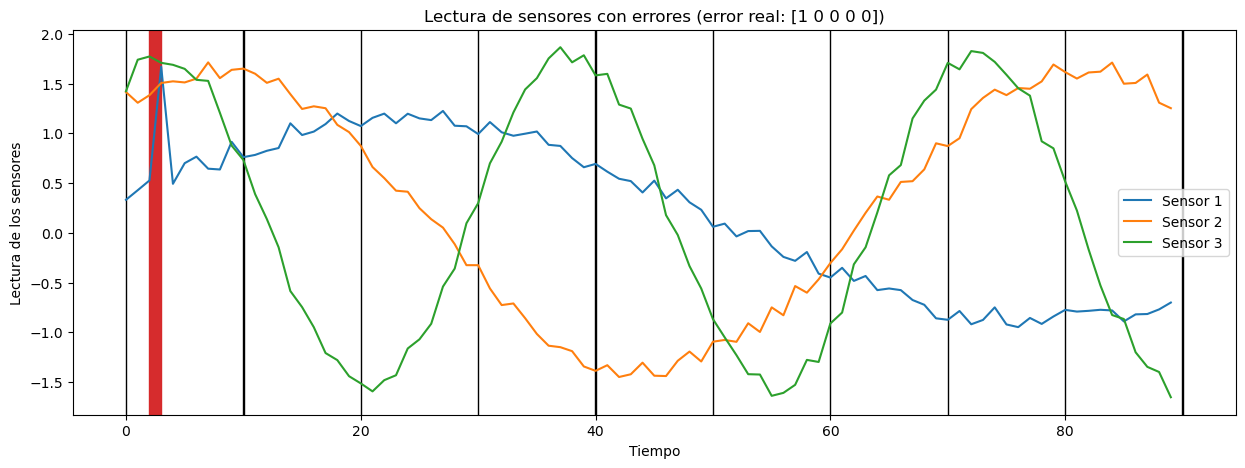

1/1 [==============================] - 0s 19ms/step


Errores detectados:
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]

Los sensores con errores predecidos son: []


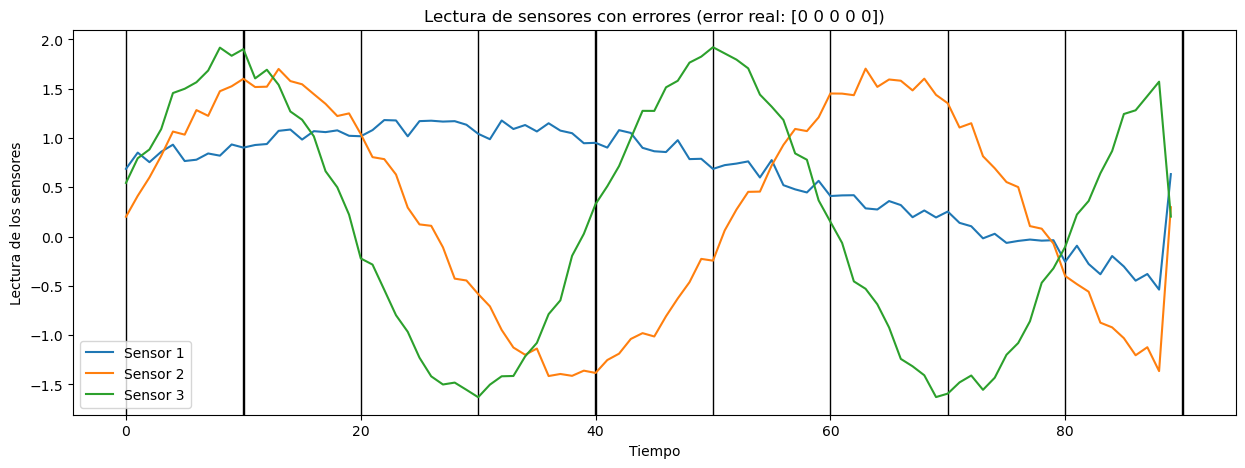

1/1 [==============================] - 0s 21ms/step


Errores detectados:
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]

Los sensores con errores predecidos son: [4]


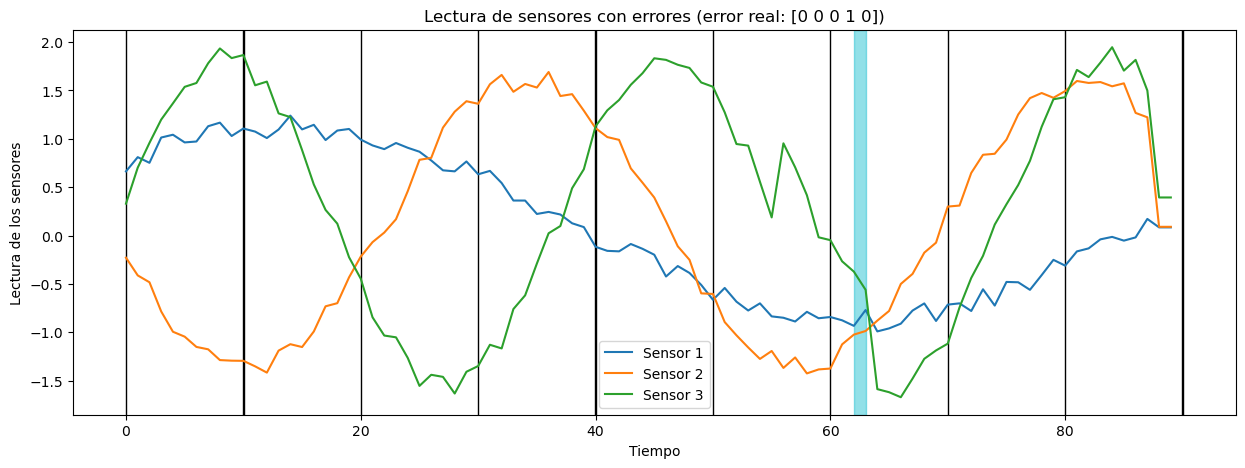

1/1 [==============================] - 0s 19ms/step


Errores detectados:
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]

Los sensores con errores predecidos son: [4, 5]


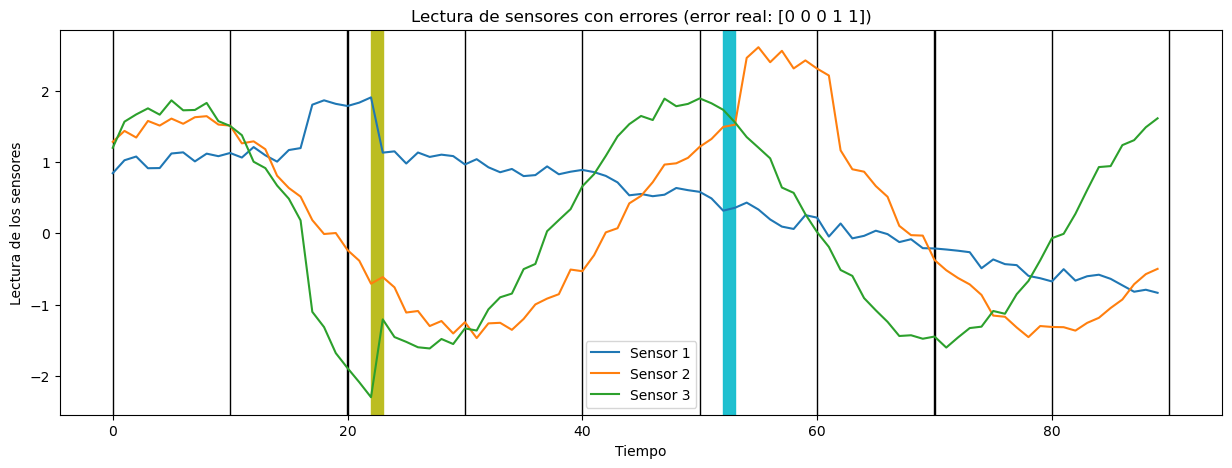

1/1 [==============================] - 0s 23ms/step


Errores detectados:
[0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0.]

Los sensores con errores predecidos son: [2, 4, 5]


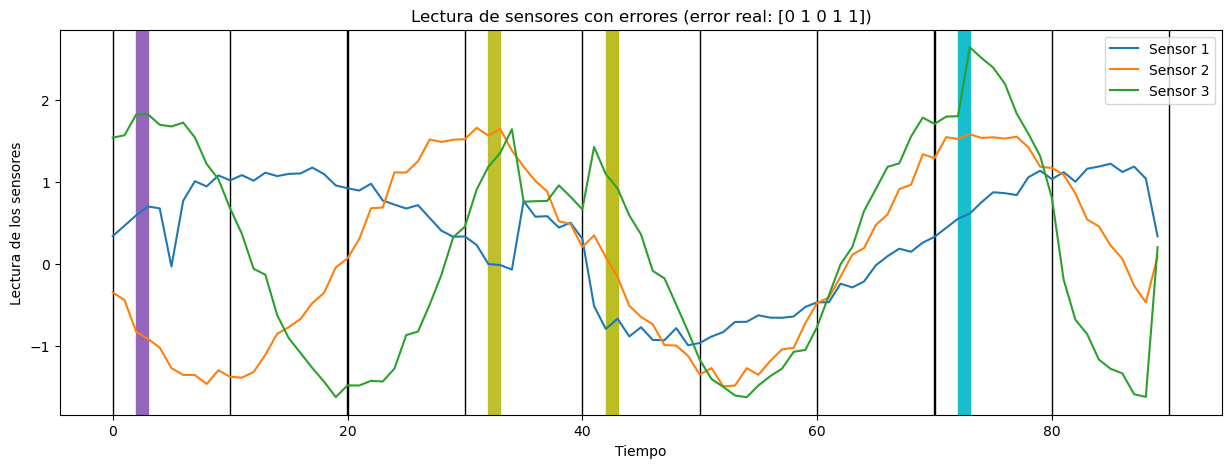

1/1 [==============================] - 0s 24ms/step


Errores detectados:
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]

Los sensores con errores predecidos son: [4]


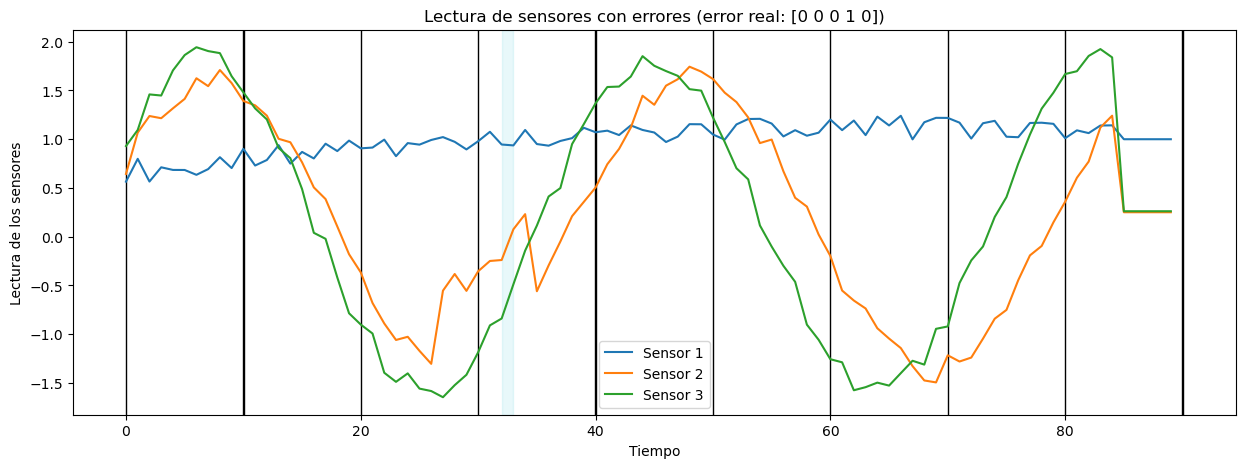

1/1 [==============================] - 0s 24ms/step


Errores detectados:
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0.]
[0. 0. 0. 0. 1.]

Los sensores con errores predecidos son: [1, 5]


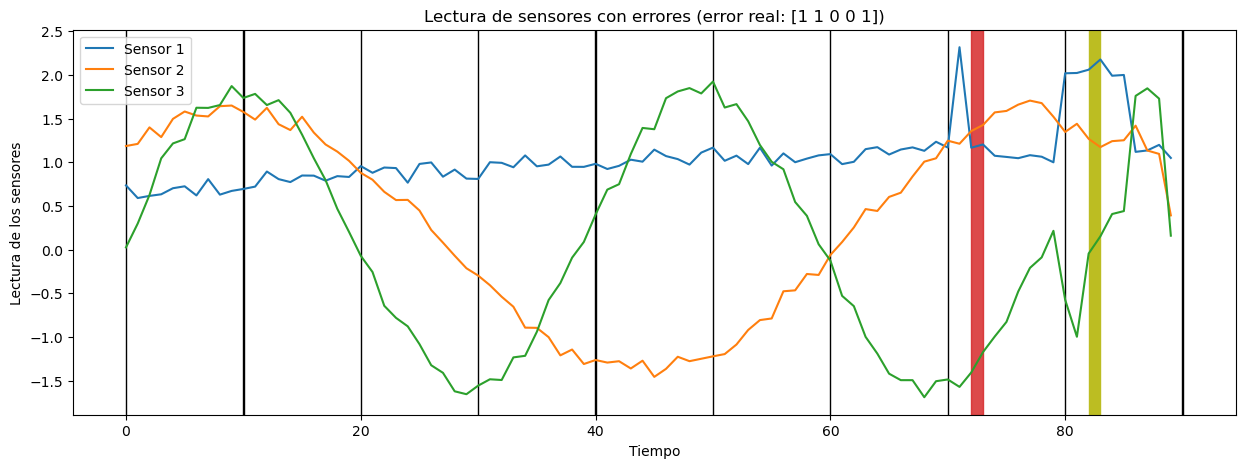

1/1 [==============================] - 0s 22ms/step


Errores detectados:
[1. 0. 0. 0. 0.]
[0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0.]

Los sensores con errores predecidos son: [1, 2]


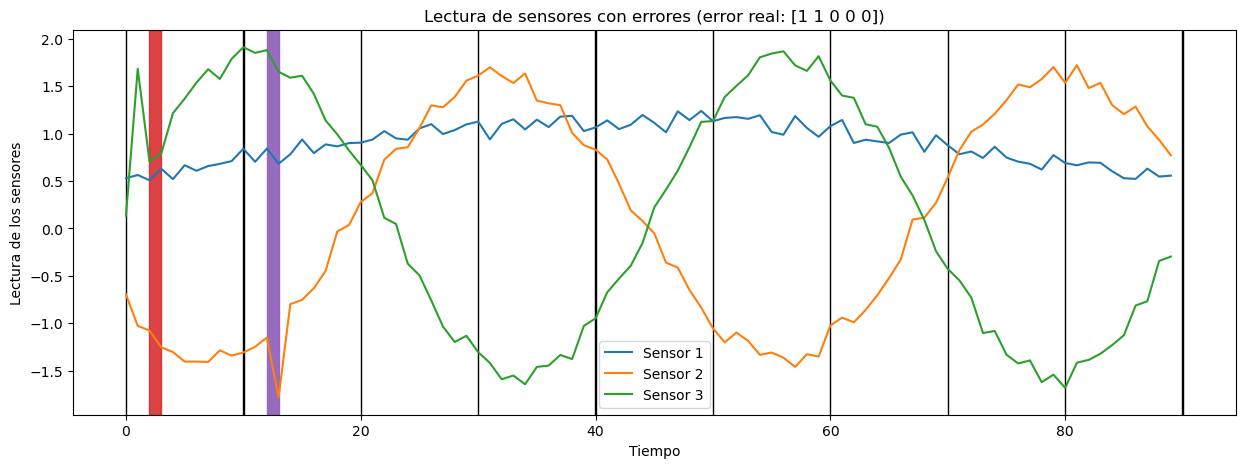

In [56]:
# Visualizar 10 lecturas diferentes  
for i in range(10):
    index = np.random.randint(len(x_test))
    plot_sensor_data_with_errors(x_test[index], y_test[index])


<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<p><strong>Comentarios:</strong></p>
<p>Entre los errores detectados, el del metro creo que debe ser el error 5, que es el que tiene mas probabilidad de aparecer, además en los 10 ejemplos, se detectan casi siempre en dos secuencias seguidas, que puede ser el tiempo que tarda en pasar el metro por debajo de los sensores.</p>
</div>